<a href="https://colab.research.google.com/github/JessicaaaJe/Jesscia_Data_Mining_Project/blob/main/Classification_II_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classification II Project
Jessica Chen

In [ ]:
'''
Import for Classification II Project
'''

import math
import random
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

import numpy as np
from numpy import mean
from numpy import std



from sklearn.metrics import get_scorer_names, accuracy_score, f1_score
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import sklearn.utils.parallel
from sklearn import neighbors
from sklearn.metrics import balanced_accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from IPython.core.completer import keyword

import warnings
warnings.filterwarnings('ignore')


# load in the data set to be classified.
x = np.loadtxt("/content/drive/MyDrive/share_folders_csc373/Data/heart_2020_cleaned_comb_num.csv",\
                   skiprows=1, delimiter=",", dtype="int")



### Basic Metrics Performance Measurement Function



In [ ]:
def TP(cm):
    # this gives back the number of columns.
    nc = len(cm[1])
    tp = [0]*nc

    # assign tp with the true positive values.
    for i in range(nc):
        tp[i] = cm[i][i]
    return tp

In [ ]:
def FP(cm):
  # subtract the instances that were predicted to belong to the class by the True positive, we then get the false mnegative.
    return [sum(cm[:, col]) - cm[col, col] for col in range(cm.shape[1])]

In [ ]:
def TN(cm):
    total = np.sum(cm)
    tp = TP(cm)
    fp = FP(cm)
    col_sums = np.sum(cm, axis=0)
    row_sums = np.sum(cm, axis=1)
    # tp[i] + fp[i] + row_sums[i]) gives the total count of
    # samples that either belong to class i or were predicted as class i.
    # subtracting this value from the overall total, we get the true negative.
    return [total - (tp[i] + fp[i] + row_sums[i]) for i in range(cm.shape[1])]


In [ ]:
def FN(cm):
  # sum of elements in the row minus the diagonal element gives the false negatives.
    return [sum(cm[row]) - cm[row, row] for row in range(cm.shape[0])]

In [ ]:
def accuracy(tp, tn, fp, fn):
    # accuracy = (tp+tn) / (tp+tn+fp+fn)
    return [(tp[i] + tn[i]) / (tp[i] + tn[i] + fp[i] + fn[i]) for i in range(len(tp))]

In [ ]:
def F1(tp, fp, fn):
    # F1 = 2*(precision * recall) /(precision + recall)
    # precision = tp(tp+fp); recall = tp/(tp+fp)
    precision = [tp[i] / (tp[i] + fp[i]) if tp[i] + fp[i] != 0 else 0 for i in range(len(tp))]
    recall = [tp[i] / (tp[i] + fn[i]) if tp[i] + fn[i] != 0 else 0 for i in range(len(tp))]
    return [2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if precision[i] + recall[i] != 0 else 0 for i in range(len(tp))]


In [ ]:
def TPR(tp, fn):
    # true positive rate
    # tp = tp / (tp+fn)
    return [tp[i] / (tp[i] + fn[i]) if tp[i] + fn[i] != 0 else 0 for i in range(len(tp))]


### Macro Measurement Functions
 Macro-average gives each class equal importance, so we calcualted statistics by independently calculating for each class and then taking the average over the classes.

In [ ]:
def macro_TPR(tp,cm):
    # an argument of tp list is given.
    # fn represents the false negative list.
    fn = FN(cm)
    tpr_list = TPR(tp, fn)
    # each class is weighted equally.
    return sum(tpr_list) / len(tpr_list)

In [ ]:
def macro_F1(f1):
    return sum(f1) / len(f1)

In [ ]:
def macro_ACCURACY(acc):
    return sum(acc) / len(acc)


In [ ]:
def class_conf_mat(cl, tp, tn, fp, fn):
  # cl represents a specific class
    return [[tp[cl], fp[cl]], [fn[cl], tn[cl]]]

### Micro-average Functions
Micro-average is calculated by counting the total true positives, false negatives, and false positives across all classes.

In [ ]:
def micro_conf_mat(tp, tn, fp, fn):
    # creates a 2*2 matrix with predicted positive on the first row and predicted negative on the second row.
    mcm = [[sum(tp), sum(fp)], [sum(fn), sum(tn)]]
    return mcm


In [ ]:
def micro_TPR(cm):
    # Computes the sum of all true positives from the confusion matrix.
    tp_sum = sum([cm[i][i] for i in range(len(cm))])
    # Computes the sum of all false negatives.
    fn_sum = sum([sum(cm[row]) - cm[row][row] for row in range(len(cm))])
    return tp_sum / (tp_sum + fn_sum)


In [ ]:
def micro_F1(cm):
    tp_sum = sum([cm[i][i] for i in range(len(cm))])
    fp_sum = sum([sum(row) - row[i] for i, row in enumerate(cm)])
    fn_sum = sum([sum(col[i] for col in cm) - cm[i][i] for i in range(len(cm))])
    precision = tp_sum / (tp_sum + fp_sum)
    recall = tp_sum / (tp_sum + fn_sum)
    return 2 * precision * recall / (precision + recall)

In [ ]:

def micro_ACCURACY(cm):
    tp_sum = sum([cm[i][i] for i in range(len(cm))])
    total = np.sum(cm)
    return tp_sum / total

## KNN Classification

In [ ]:
print("Begin classification using", MODEL_TYPE)

Begin classification using KNN


In [ ]:
# set up the parameters
RESAMPLE = None
MODEL_TYPE = "KNN"
TEST_SET_SIZE = 0.2

# KNN algorithm is time inefficient. I choose to reduce the dimensionality to fast the classficiation.
# IT retain 95% variance when using PCA
PCA_COMPONENTS = 0.95
KNN_N_NEIGHBORS = 5

In [ ]:
# Extract x and y from the loaded dataset.
X = x[:, :-1]
y = x[:, -1]

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SET_SIZE, random_state=42)


In [ ]:
# Apply PCA for dimensionality reduction and efficient classification.
pca = PCA(n_components=PCA_COMPONENTS)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Build up KNN Model.
# n_jobs = -1 put all available CPU in the computer to fast the classification Process.
knn = KNeighborsClassifier(n_neighbors=KNN_N_NEIGHBORS,n_jobs=-1)
knn.fit(X_train_pca, y_train)
y_pred = knn.predict(X_test_pca)

### KNN Multi-Class performance measurement

##### The result gives out a confusion matrix for the dataset that has 4 response variable (HD_kD) classes: 0, 1, 2, 3.

The main diagonal [44942, 5, 172, 0] represents the number of correct predictions for each class, from class 1 to class 4, respectively. The other numbers outside this diagonal represent misclassifications.

In [ ]:
NUM_CLASSES = len(set(y_train))

conf_mat = [[0]*NUM_CLASSES for _ in range(NUM_CLASSES)]
err_cnt = 0

# Use y_test for true labels, so the row represents the actual class.
for i, val in enumerate(y_test):
  # Use y_pred for predicted labels, the column represent the predicted class.
  conf_mat[val][y_pred[i]] += 1

print("Confusion matrix:")
for i in conf_mat:
  print(i)

Confusion matrix:
[44942, 40, 559, 11]
[1217, 5, 48, 1]
[3630, 16, 172, 6]
[535, 5, 32, 0]


In [ ]:
# initialize c_mat to be assigned with values of confusion matrix.
c_mat = [[ 8,  5,  20],
         [ 2, 10,  10],
         [ 5,  5, 270]]


c_mat = np.array(conf_mat)

#Determine overall accuracy
total_cnt = 0
total_correct = 0
for i in range(NUM_CLASSES):
  for j in range(NUM_CLASSES):
    total_cnt += c_mat[i][j]
    if i==j:
      total_correct += c_mat[i][j]
overall_acc = total_correct/total_cnt
print("total count:", total_cnt)
print("total correct:", total_correct)
print("overall accuracy %3.3f" % overall_acc)

# get the statistics for each class.
tp = TP(c_mat)
fp = FP(c_mat)
tn = TN(c_mat)
fn = FN(c_mat)
acc = accuracy(tp, tn, fp, fn)
acc = [round(x, 3) for x in acc]
tpr = TPR(tp, fn)
tpr = [round(x, 3) for x in tpr]
f1 = F1(tp, fp, fn)
f1 = [round(x, 3) for x in f1]

# -------macro meausrements-----.
# Macro accuracy computes the metric independently for each class and then takes the average.
macro_tpr = macro_TPR(tpr, c_mat)
macro_f1 = macro_F1(f1)
macro_acc = macro_ACCURACY(acc)


# -------micro measurements-----.
# Micro accuracy aggregates the contributions of all the classes to compute the average metric.
micro_c_mat = micro_conf_mat(tp, tn, fp, fn)

for i in range(2):
  for j in range(2):
    micro_c_mat[i][j] = round(micro_c_mat[i][j], 3)

micro_tpr = micro_TPR(micro_c_mat)
micro_f1 = micro_F1(micro_c_mat)
micro_acc = micro_ACCURACY(micro_c_mat)


print("\nClass metrics.")
print("TP:", tp)
print("FP:", fp)
print("TN:", tn)
print("FN:", fn)
print("Accuracy:", acc)
print("TPR:", tpr)
print("F1:", f1)

print("\nMacro metrics.")
print("Macro TPR: %2.3f" % macro_tpr)
print("Macro F1: %2.3f" % macro_f1)
print("Macro ACC: %2.3f" % macro_acc)

print("\nClass confusion matrices:")
for i in range(len(tp)):
  class_c_mat = class_conf_mat(i, tp, tn, fp, fn)
  print("Class ", i)
  print(class_c_mat)


print("\nMicro confusion matrix:")
for row in micro_c_mat:
  print(row)
print("\nMicro metrics.")
print("Micro TPR: %2.3f" % micro_tpr)
print("Micro F1: %2.3f" % micro_f1)
print("Micro ACC: %2.3f" % micro_acc)


total count: 51219
total correct: 45119
overall accuracy 0.881

Class metrics.
TP: [44942, 5, 172, 0]
FP: [5382, 61, 639, 18]
TN: [-44657, 49882, 46584, 50629]
FN: [610, 1266, 3652, 572]
Accuracy: [0.045, 0.974, 0.916, 0.988]
TPR: [0.987, 0.004, 0.045, 0.0]
F1: [0.938, 0.007, 0.074, 0]

Macro metrics.
Macro TPR: 0.000
Macro F1: 0.255
Macro ACC: 0.731

Class confusion matrices:
Class  0
[[44942, 5382], [610, -44657]]
Class  1
[[5, 61], [1266, 49882]]
Class  2
[[172, 639], [3652, 46584]]
Class  3
[[0, 18], [572, 50629]]

Micro confusion matrix:
[45119, 6100]
[6100, 102438]

Micro metrics.
Micro TPR: 0.924
Micro F1: 0.924
Micro ACC: 0.924


##### As indicated by the code below. Class 1 represents a significant majority of the data 88.83734552% while the other classes are under-represented in comparison, there is a class imbalance in the dataset. Usually, macro statistics would provide better evaluation on this dataset.
I will test on K values from 1 to 21 to determine how these accuracy change


In [ ]:
# 1. Extract unique classes and their counts
(unique, counts) = np.unique(y, return_counts=True)
print("Unique Classes:", unique)
print("Counts:", counts)

# 2. Calculate the proportion of each class
total_samples = len(y)
class_proportions = counts / total_samples * 100
print("Class Proportions (%):", class_proportions)


Unique Classes: [0 1 2 3]
Counts: [227508   6633  19184   2770]
Class Proportions (%): [88.83734552  2.59005447  7.49097015  1.08162986]


### KNN - test on different hyperparameters

From the graph, we could see that all accuracies experience a significant increase when K approaches to 2, but stay relatively stable after that.
And overall, micro statistics have the best performance.

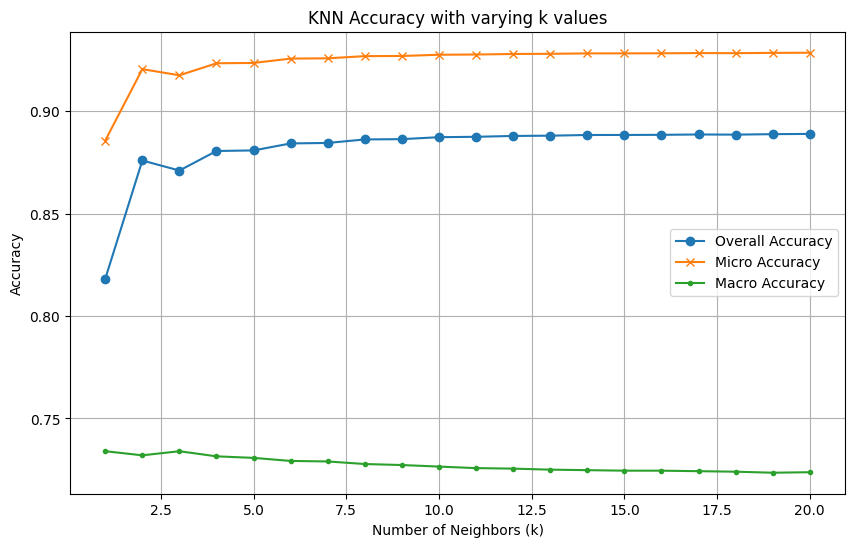

In [ ]:
# testing K from 1 to 20
k_values = range(1, 21)

# Store accuracies for each K value

macro_accuracies = []
micro_accuracies = []
overall_accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train_pca, y_train)
    y_pred = knn.predict(X_test_pca)


    # ----* calcualte macro accuracy *---- #.
    NUM_CLASSES = len(set(y_train))

    conf_mat = [[0]*NUM_CLASSES for _ in range(NUM_CLASSES)]
    err_cnt = 0

    # Use y_test for true labels, so the row represents the actual class.
    for i, val in enumerate(y_test):
    # Use y_pred for predicted labels, the column represent the predicted class.
      conf_mat[val][y_pred[i]] += 1



    c_mat = [[ 8,  5,  20],
            [ 2, 10,  10],
            [ 5,  5, 270]]


    c_mat = np.array(conf_mat)

    # get the statistics for each class.
    tp = TP(c_mat)
    fp = FP(c_mat)
    tn = TN(c_mat)
    fn = FN(c_mat)
    acc = accuracy(tp, tn, fp, fn)
    acc = [round(x, 3) for x in acc]

    macro_acc = macro_ACCURACY(acc)
    macro_accuracies.append(macro_acc)


    # ----* calcualte micro accuracy *---- #.
    micro_c_mat = micro_conf_mat(tp, tn, fp, fn)

    for i in range(2):
      for j in range(2):
        micro_c_mat[i][j] = round(micro_c_mat[i][j], 3)

    micro_acc = micro_ACCURACY(micro_c_mat)
    micro_accuracies.append(micro_acc)


     # ----* calcualte overall accuracy *---- #.
    total_cnt = 0
    total_correct = 0
    for i in range(NUM_CLASSES):
      for j in range(NUM_CLASSES):
        total_cnt += c_mat[i][j]
        if i==j:
          total_correct += c_mat[i][j]

    overall_acc = total_correct/total_cnt
    overall_accuracies.append(overall_acc)

plt.figure(figsize=(10, 6))
plt.plot(k_values, overall_accuracies, marker='o', label='Overall Accuracy')
plt.plot(k_values, micro_accuracies, marker='x', label='Micro Accuracy')
plt.plot(k_values, macro_accuracies, marker='.', label='Macro Accuracy')

plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy with varying k values')
plt.legend()
plt.grid(True)
plt.show()

# Random Forest Classification

In [ ]:
# Delineate hyperparameters
N_ESTIMATORS = 100    # Number of trees in the forest
MAX_DEPTH = None      # Maximum depth of the trees
MIN_SAMPLES_SPLIT = 2 # Minimum number of samples required to split an internal node
MIN_SAMPLES_LEAF = 1  # Minimum number of samples required to be at a leaf node
RANDOM_STATE = 42     # Random state for reproducibility

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SET_SIZE, random_state=RANDOM_STATE)

In [ ]:
# Initialize and train the Random Forest model

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Build up random forest Model.
# n_jobs = -1 put all available CPU in the computer to fast the classification Process.
clf = RandomForestClassifier(n_estimators=N_ESTIMATORS,
                             max_depth=MAX_DEPTH,
                             min_samples_split=MIN_SAMPLES_SPLIT,
                             min_samples_leaf=MIN_SAMPLES_LEAF,
                             random_state=RANDOM_STATE)
clf.fit(X_train_pca, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Predict using the test set
y_pred = clf.predict(X_test_pca)

### RF Multi-Class performance measurement

In [ ]:
NUM_CLASSES = len(set(y_train))

conf_mat = [[0]*NUM_CLASSES for _ in range(NUM_CLASSES)]
err_cnt = 0
# Use y_test for true labels, so the row represents the actual class.
for i, val in enumerate(y_test):
  # Use y_pred for predicted labels, the column represent the predicted class.
  conf_mat[val][y_pred[i]] += 1

print("Confusion matrix:")
for i in conf_mat:
  print(i)

Confusion matrix:
[44461, 184, 848, 59]
[1211, 9, 47, 4]
[3506, 51, 240, 27]
[503, 7, 54, 8]


In [ ]:
c_mat = [[ 8,  5,  20],
         [ 2, 10,  10],
         [ 5,  5, 270]]


c_mat = np.array(conf_mat)

#Determine overall accuracy
total_cnt = 0
total_correct = 0
for i in range(NUM_CLASSES):
  for j in range(NUM_CLASSES):
    total_cnt += c_mat[i][j]
    if i==j:
      total_correct += c_mat[i][j]
overall_acc = total_correct/total_cnt
print("total count:", total_cnt)
print("total correct:", total_correct)
print("overall accuracy %3.3f" % overall_acc)

print("\nConfusion matrix:")
for row in c_mat:
      print(row)

tp = TP(c_mat)
fp = FP(c_mat)
tn = TN(c_mat)
fn = FN(c_mat)
acc = accuracy(tp, tn, fp, fn)
acc = [round(x, 3) for x in acc]
tpr = TPR(tp, fn)
tpr = [round(x, 3) for x in tpr]
f1 = F1(tp, fp, fn)
f1 = [round(x, 3) for x in f1]


total count: 51219
total correct: 44718
overall accuracy 0.873

Confusion matrix:
[44461   184   848    59]
[1211    9   47    4]
[3506   51  240   27]
[503   7  54   8]


In [ ]:
macro_tpr = macro_TPR(tpr, c_mat)
macro_f1 = macro_F1(f1)
macro_acc = macro_ACCURACY(acc)

micro_c_mat = micro_conf_mat(tp, tn, fp, fn)


for i in range(2):
  for j in range(2):
    micro_c_mat[i][j] = round(micro_c_mat[i][j], 3)

micro_tpr = micro_TPR(micro_c_mat)
micro_f1 = micro_F1(micro_c_mat)
micro_acc = micro_ACCURACY(micro_c_mat)

In [ ]:
print("\nClass metrics.")
print("TP:", tp)
print("FP:", fp)
print("TN:", tn)
print("FN:", fn)
print("Accuracy:", acc)
print("TPR:", tpr)
print("F1:", f1)

print("\nMacro metrics.")
print("Macro TPR: %2.3f" % macro_tpr)
print("Macro F1: %2.3f" % macro_f1)
print("Macro ACC: %2.3f" % macro_acc)

print("\nClass confusion matrices:")
for i in range(len(tp)):
  class_c_mat = class_conf_mat(i, tp, tn, fp, fn)
  print("Class ", i)
  print(class_c_mat)

print("\nMicro confusion matrix:")
for row in micro_c_mat:
  print(row)
print("\nMicro metrics.")
print("Micro TPR: %2.3f" % micro_tpr)
print("Micro F1: %2.3f" % micro_f1)
print("Micro ACC: %2.3f" % micro_acc)


Class metrics.
TP: [44461, 9, 240, 8]
FP: [5220, 242, 949, 90]
TN: [-44014, 49697, 46206, 50549]
FN: [1091, 1262, 3584, 564]
Accuracy: [0.066, 0.971, 0.911, 0.987]
TPR: [0.976, 0.007, 0.063, 0.014]
F1: [0.934, 0.012, 0.096, 0.024]

Macro metrics.
Macro TPR: 0.000
Macro F1: 0.267
Macro ACC: 0.734

Class confusion matrices:
Class  0
[[44461, 5220], [1091, -44014]]
Class  1
[[9, 242], [1262, 49697]]
Class  2
[[240, 949], [3584, 46206]]
Class  3
[[8, 90], [564, 50549]]

Micro confusion matrix:
[44718, 6501]
[6501, 102438]

Micro metrics.
Micro TPR: 0.919
Micro F1: 0.919
Micro ACC: 0.919


##### Micro ACC = 0.919, Macro ACC = 0.734.
It is not a huge difference between random forest and KNN. And Micro statistics is still better performed.

### Testing with different Parameters.
These two parameters N_ESTIMATORS and MAX_DEPTH usually have the most direct impact on the accuracy. So, I will test on the accuracy change on these two parameters.

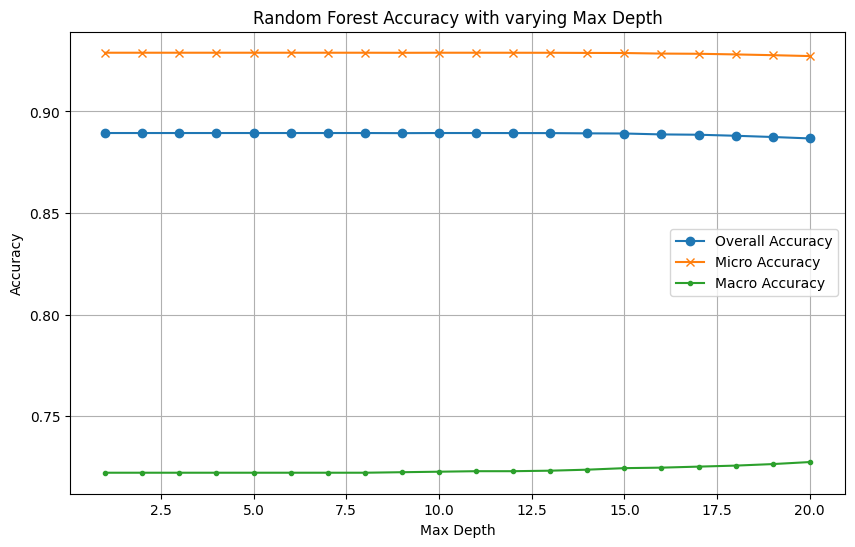

In [ ]:
depth_values = range(1, 21)

# Store accuracies for each K value

macro_accuracies = []
micro_accuracies = []
overall_accuracies = []

for depth in depth_values:
    rf = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=42, n_jobs=-1)
    rf.fit(X_train_pca, y_train)
    y_pred = rf.predict(X_test_pca)

    # ----* calcualte macro accuracy *---- #.
    NUM_CLASSES = len(set(y_train))

    conf_mat = [[0]*NUM_CLASSES for _ in range(NUM_CLASSES)]
    err_cnt = 0

    # Use y_test for true labels, so the row represents the actual class.
    for i, val in enumerate(y_test):
    # Use y_pred for predicted labels, the column represent the predicted class.
      conf_mat[val][y_pred[i]] += 1



    c_mat = [[ 8,  5,  20],
            [ 2, 10,  10],
            [ 5,  5, 270]]


    c_mat = np.array(conf_mat)

    # get the statistics for each class.
    tp = TP(c_mat)
    fp = FP(c_mat)
    tn = TN(c_mat)
    fn = FN(c_mat)
    acc = accuracy(tp, tn, fp, fn)
    acc = [round(x, 3) for x in acc]

    macro_acc = macro_ACCURACY(acc)
    macro_accuracies.append(macro_acc)


    # ----* calcualte micro accuracy *---- #.
    micro_c_mat = micro_conf_mat(tp, tn, fp, fn)

    for i in range(2):
      for j in range(2):
        micro_c_mat[i][j] = round(micro_c_mat[i][j], 3)

    micro_acc = micro_ACCURACY(micro_c_mat)
    micro_accuracies.append(micro_acc)


     # ----* calcualte overall accuracy *---- #.
    total_cnt = 0
    total_correct = 0
    for i in range(NUM_CLASSES):
      for j in range(NUM_CLASSES):
        total_cnt += c_mat[i][j]
        if i==j:
          total_correct += c_mat[i][j]

    overall_acc = total_correct/total_cnt
    overall_accuracies.append(overall_acc)

plt.figure(figsize=(10, 6))
plt.plot(depth_values, overall_accuracies, marker='o', label='Overall Accuracy')
plt.plot(depth_values, micro_accuracies, marker='x', label='Micro Accuracy')
plt.plot(depth_values, macro_accuracies, marker='.', label='Macro Accuracy')

plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Random Forest Accuracy with varying Max Depth')
plt.legend()
plt.grid(True)
plt.show()

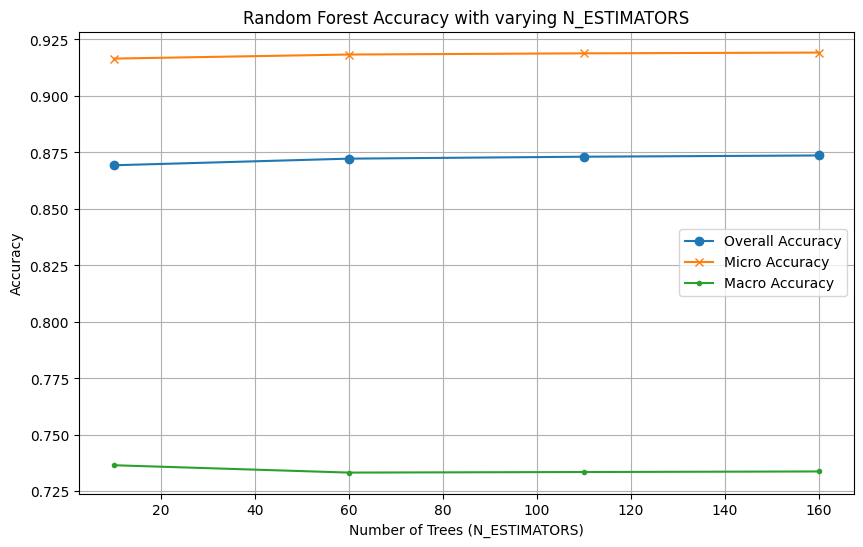

In [ ]:
# set the number of trees ranging from 10 - 201, in an interval of 50 to make it more efficient.
n_estimators_values = range(10, 201, 50)

# Store accuracies for each algorithm

macro_accuracies = []
micro_accuracies = []
overall_accuracies = []


# Constants
MAX_DEPTH = None
MIN_SAMPLES_SPLIT = 2
MIN_SAMPLES_LEAF = 1
RANDOM_STATE = 42


for n in n_estimators_values:
    rf = RandomForestClassifier(n_estimators=n, max_depth=MAX_DEPTH, min_samples_split=MIN_SAMPLES_SPLIT,
                                min_samples_leaf=MIN_SAMPLES_LEAF, random_state=RANDOM_STATE, n_jobs=-1)
    rf.fit(X_train_pca, y_train)
    y_pred = rf.predict(X_test_pca)


    # ----* calcualte macro accuracy *---- #.
    NUM_CLASSES = len(set(y_train))

    conf_mat = [[0]*NUM_CLASSES for _ in range(NUM_CLASSES)]
    err_cnt = 0

    # Use y_test for true labels, so the row represents the actual class.
    for i, val in enumerate(y_test):
    # Use y_pred for predicted labels, the column represent the predicted class.
      conf_mat[val][y_pred[i]] += 1



    c_mat = [[ 8,  5,  20],
            [ 2, 10,  10],
            [ 5,  5, 270]]


    c_mat = np.array(conf_mat)

    # get the statistics for each class.
    tp = TP(c_mat)
    fp = FP(c_mat)
    tn = TN(c_mat)
    fn = FN(c_mat)
    acc = accuracy(tp, tn, fp, fn)
    acc = [round(x, 3) for x in acc]

    macro_acc = macro_ACCURACY(acc)
    macro_accuracies.append(macro_acc)


    # ----* calcualte micro accuracy *---- #.
    micro_c_mat = micro_conf_mat(tp, tn, fp, fn)

    for i in range(2):
      for j in range(2):
        micro_c_mat[i][j] = round(micro_c_mat[i][j], 3)

    micro_acc = micro_ACCURACY(micro_c_mat)
    micro_accuracies.append(micro_acc)


     # ----* calcualte overall accuracy *---- #.
    total_cnt = 0
    total_correct = 0
    for i in range(NUM_CLASSES):
      for j in range(NUM_CLASSES):
        total_cnt += c_mat[i][j]
        if i==j:
          total_correct += c_mat[i][j]

    overall_acc = total_correct/total_cnt
    overall_accuracies.append(overall_acc)


plt.figure(figsize=(10, 6))
plt.plot(n_estimators_values, overall_accuracies, marker='o', label='Overall Accuracy')
plt.plot(n_estimators_values, micro_accuracies, marker='x', label='Micro Accuracy')
plt.plot(n_estimators_values, macro_accuracies, marker='.', label='Macro Accuracy')
plt.xlabel('Number of Trees (N_ESTIMATORS)')
plt.ylabel('Accuracy')
plt.title('Random Forest Accuracy with varying N_ESTIMATORS')
plt.legend()
plt.grid(True)
plt.show()